In [2]:
import utils
import cv2
import imutils
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import skimage
from sklearn.cluster import KMeans
from collections import Counter

In [3]:
train = True
'''
import utils
import cv2
import imutils
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import random as rng
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from tqdm.notebook import trange,tqdm

import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True' # needed on my laptop due to an error when calling plt.imshow() (kernel died)
# reference: https://jovian.ai/forum/t/jupyter-kernel-died-after-plt-imshow-tensor-obj/14830

# Crop out relevant image with help of the mask
mask = cv2.imread('data_WiSAR/data/mask.png', cv2.IMREAD_GRAYSCALE)
_, mask = cv2.threshold(mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)

def cropOut(image):
    image_x, image_y,_ = image.shape
    mask_x, mask_y = mask.shape

    x_mask = min(image_x, mask_x)
    x_half_mask = mask.shape[0]//2

    mask_mask = mask[x_half_mask-x_mask//2 : x_half_mask+x_mask//2+1, :image_y]

    image_width_half = image.shape[1]//2
    image_to_mask = image[:,image_width_half-x_half_mask:image_width_half+x_half_mask]
    masked = cv2.bitwise_and(image_to_mask,image_to_mask,mask = mask_mask)
    return masked

# Read train images
datafolder = 'data_WiSAR/data/train/'

dirs = os.listdir(datafolder)

raw_train_img = dict()
homography_files = []
pbar = tqdm(dirs)
for act_dir in pbar:
    raw_train_img[act_dir] = dict()
    samples = glob.glob(datafolder+act_dir+'/*.png')
    for img in samples:
        file = os.path.basename(img)
        img_name = os.path.splitext(file)[0]
        #src = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB) # Read images using imread function and convert color space using cvtColor
        #src = cv2.imread(img) # standard is BGR
        src = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
        
        src = np.reshape(src, (1024, 1024, 3))
        #src = cv2.imread(img, cv2.IMREAD_GRAYSCALE) # standard is BGR
        
        # crop out image with mask
        src = cropOut(src)
        
        # resize image
        #width = 256#int(src.shape[1] * scale_percent / 100)
        #height = 256#int(src.shape[0] * scale_percent / 100)
        #dim = (width, height)
        #src = cv2.resize(src, dim, interpolation = cv2.INTER_AREA)
        
        src = np.reshape(src, (src.shape[1], src.shape[0], 3))
        src = src.astype('float32') / 255.        
        
        raw_train_img[act_dir][img_name]=src
    # read in homographies.json
    f = glob.glob(datafolder+act_dir+'/*.json')
    homography_files.append(f)
    pbar.set_postfix_str(f"Current sample directory: {act_dir}")
    
arrays = [raw_train_img['train-1-0'][i] for i in raw_train_img['train-1-0']]
trainImages = np.stack(arrays)

arrays = [raw_train_img['train-2-0'][i] for i in raw_train_img['train-2-0']]
testImages = np.stack(arrays)
print(trainImages.shape)
print(testImages.shape)
x_train = trainImages
x_test = testImages
'''

'\nimport utils\nimport cv2\nimport imutils\nimport glob\nimport os\nimport numpy as np\nimport json\nimport matplotlib.pyplot as plt\nimport random as rng\nimport torch\nimport torch.nn as nn\nfrom torch.autograd import Variable\nfrom torch.utils.data import DataLoader\nfrom torchvision import transforms\nfrom torchvision.datasets import MNIST\nfrom torchvision.utils import save_image\nfrom tqdm.notebook import trange,tqdm\n\nimport os    \nos.environ[\'KMP_DUPLICATE_LIB_OK\']=\'True\' # needed on my laptop due to an error when calling plt.imshow() (kernel died)\n# reference: https://jovian.ai/forum/t/jupyter-kernel-died-after-plt-imshow-tensor-obj/14830\n\n# Crop out relevant image with help of the mask\nmask = cv2.imread(\'data_WiSAR/data/mask.png\', cv2.IMREAD_GRAYSCALE)\n_, mask = cv2.threshold(mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)\n\ndef cropOut(image):\n    image_x, image_y,_ = image.shape\n    mask_x, mask_y = mask.shape\n\n    x_mask = min(image_x, mask_x)\n   

In [4]:
class ImageMerger:
    """
    ImageMerger can merge images from a dataset including images collected by a drone with the purpose of detecting 
    moving people in the images.
    """
    def __init__(self, data_dir, mask_file):
        """
        :param data_dir: path to the directory where the data is located
        :param mask_file: path of a mask which removes unneccesary text from the images
        """
        
        # Get all directories inside the data_dir
        self.data_dir = data_dir
        self.dirs = os.listdir(data_dir)
        self.mask = np.array(cv2.imread(mask_file)) // 255
        
        # Store the merged images
        self.merged_images = {}
        
    def load_images(self):
        """
        Loads the images and homographies from one directory at a time and yields them
        """
        
        for a_dir in self.dirs:
            if a_dir == 'labels.json':
                continue
            input_images = {}
            
            # Load all images in the train directory
            image_dir_file_path = os.path.join(os.path.join(self.data_dir, a_dir), '*.png')
            images = glob.glob(image_dir_file_path)
            
            # Copy all the raw images to the input images dict
            for im in images:
                file = os.path.basename(im)
                img_name = os.path.splitext(file)[0]
                src = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
                #src = cv2.imread(im, cv2.IMREAD_GRAYSCALE)
                src = self.apply_mask(src)
                input_images[img_name] = src
            
            # Load the homographies json file
            homographies_file_path = os.path.join(os.path.join(self.data_dir, a_dir), 'homographies.json')
            with open(homographies_file_path, 'rb') as f:
                homographies = json.load(f)
            
            yield a_dir, input_images, homographies
        
    def apply_mask(self, image):
        """
        Applys the provided mask on image
        :param image: image file which will be treated as np.array
        """

        return image * self.mask
    
    def merge_images(self, alpha=0.1, axis=0, method='cltr', debug=False):
        """
        Merges all the images given the homographies which are retrieved from load_data. 
        :param alpha: Weighting for merging the images. The image to be merged on will be considered with a weight a alpha,
        the second image with a weight of 1-alpha.
        :param axis: defines the axis along which the images shall be merged. 0: camera axis, 1: time axis
        :param method: defines in which order the images shall be merged:
            - cltr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on it
                    from left to right along the camera axis or from the first in time (index 0) to the last in time (index
                    6)
            - crtl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on it
                    from right to left along the camera axis or from the last in time (index 6) to the first in time (index
                    0)
            - coutl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the center out switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the left side/previous in time. 
            - coutr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the center out switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the right side/next in time.
            - cinl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the outside inward switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the left side/previous in time. 
            - cinr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the outside inward switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the right side/next in time.
        :param debug: if True, results are printed to be able to debug 
        """
        
        # Define the keys and indices depending on axis and method
        keys = []
        indices = []
        base = None
        if axis == 0:
            indices = range(0, 7)
            if method == 'cltr':
                base = '-B01'
                keys = ['-B05', '-B04', '-B03', '-B02', '-G01', '-G02', '-G03', '-G04', '-G05']
            elif method == 'crtl': 
                base = '-B01'
                keys = ['-G05', '-G04', '-G03', '-G02', '-G01', '-B02', '-B03', '-B04', '-B05']
            elif method == 'coutl':
                base = '-B01'
                keys = ['-B02', '-G01', '-B03', '-G02', '-B04', '-G03', '-B05', '-G04', '-G05']
            elif method == 'coutr':
                base = '-B01'
                keys = ['-G01', '-B02', '-G02', '-B03', '-G03', '-B04', '-G04', '-B05', '-G05']
            elif method == 'cinl':
                base = '-B01'
                keys = ['-B05', '-G05', '-B04', '-G04', '-B03', '-G03', '-B02', '-G02', '-G01']
            elif method == 'cinr':
                base = '-B01'
                keys = ['-G05', '-B05', '-G04', '-B04', '-G03', '-B03', '-G02', '-B02', '-G01']
        elif axis == 1:
            indices = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            if method == 'cltr':
                base = 3
                keys = [0, 1, 2, 4, 5, 6]
            elif method == 'crtl': 
                base = 3
                keys = [6, 5, 4, 2, 1, 0]
            elif method == 'coutl':
                base = 3
                keys = [2, 4, 1, 5, 0, 6]
            elif method == 'coutr':
                base = 3
                keys = [4, 2, 5, 1, 6, 0]
            elif method == 'cinl':
                base = 3
                keys = [0, 6, 1, 5, 2, 4]
            elif method == 'cinr':
                base = 3
                keys = [6, 0, 5, 1, 4, 2]
                
        # Do the merging by looping through all indices and keys
        pbar = tqdm(self.load_images())
        for a_dir, images, homographies in pbar:
            # Loop through the indices
            for i in indices: 
                # Load the base image depending on the method
                base_image_key = ''
                if axis == 0:
                    base_image_key = str(i) + base
                elif axis == 1:
                    base_image_key = str(base) + i
                    
                # Define the merged image and set it to the base image as the start
                merged_image = images[base_image_key]
                
                if debug:
                    print('directory: ', a_dir)
                    print('base key: ', base_image_key)

                for k in keys:
                    # Get the key given the index and k
                    key = ''
                    if axis == 0:
                        key = str(i) + k
                    elif axis == 1:
                         key = str(k) + i
                        
                    # Load the image and the corresponding homography matrix
                    im = images[key]
                    homography = np.array(homographies[key])
                    
                    # Warp the perspective (i.e. transform the current image into the perspective of the base image (-B01))
                    im_warped = cv2.warpPerspective(im, homography, im.shape[:2])
                    # Merge the images
                    merged_image = cv2.addWeighted(merged_image, alpha, im_warped, 1 - alpha, 0.0)

                self.merged_images[a_dir+str(i)] = merged_image
                if debug:
                    plt.imshow(merged_image)
                    plt.show()
            #break
            pbar.set_postfix(a_dir=a_dir)
        return self.merged_images

In [5]:
validation_path = "\data_WiSAR\data\validation"
mask_path ="\data_WiSAR\data\mask.png"
image_merger = ImageMerger(validation_path, mask_path)
valid_images = image_merger.merge_images(axis=0, method='coutl', debug=False)

11it [00:26,  2.40s/it, a_dir=valid-2-3]


In [6]:
train_path = "\data_WiSAR\data\train"
image_merger = ImageMerger(train_path, mask_path)
train_images = image_merger.merge_images(axis=0, method='coutl', debug=False)

26it [00:54,  2.11s/it, a_dir=train-2-9]


In [16]:
def mahalanobis(image, threshold=4):

    array = image.copy()
    Xpix = array.shape[0]
    Ypix = array.shape[1]
    
    # offset because of black regions:
    xOffset = 110
    yOffsetDown = 300
    yOffsetUp = 1024 - 950
    
    mean_vector = np.mean(array, axis=(0, 1))
    
    reshaped_array = array.reshape((Xpix * Ypix, 3))

    number=100000
    # sample the above array to reduce computing time
    choices = np.random.randint(0, len(reshaped_array), number)
    reshaped_array = np.array([reshaped_array[i] for i in choices])
    average = np.mean(reshaped_array)
    # compute the variance-covariance matrix for these RGB data
    matrix = np.array(sum([np.outer(np.array([reshaped_array[i] - \
       average]), np.array(reshaped_array[i] - average)) for i in \
        range(len(reshaped_array))]) / len(reshaped_array))

    variance_covariance = np.linalg.inv(matrix)

    # iterate over the original image and store dM in this new array
    distances = np.zeros([Xpix, Ypix])
    for i in range(yOffsetDown, Xpix-yOffsetUp):
        for j in range(xOffset, Ypix):
            distances[i][j] = np.sqrt(np.dot(np.dot(np.transpose(array[i][j] - mean_vector), variance_covariance),array[i][j] - mean_vector))

    anomaly = np.zeros_like(distances)
    purified = array.copy()
    
    for i in range(yOffsetDown, Xpix-yOffsetUp):
        for j in range(xOffset, Ypix):
            if distances[i,j] > threshold:
                window = array[i-25:i+25, j-25: j+25]
                clt = KMeans(n_clusters=3)
                clt.fit(window.reshape(-1,3))
                #unique, counts = np.unique(window.reshape(-1, 3), axis=0, return_counts=True)
                anomaly[i,j] = 1
                counter = Counter(clt.labels_)
                #print(counter.most_common(2)[0][0],counter.most_common(2)[1][0])
                #purified[i,j,0], purified[i,j,1], purified[i,j,2] = unique[np.argmax(counts)]
                #print(clt.cluster_centers_[0].astype(np.uint8))
                purified[i,j,0], purified[i,j,1], purified[i,j,2] = clt.cluster_centers_[counter.most_common(2)[1][0]].astype(np.uint8)
            else:
                anomaly[i,j] = 0
        
    return distances, anomaly, purified

purified_train_images = []
for i in range(1):
    distances, anomaly, purified = mahalanobis(train_images['train-1-0'+str(i)], threshold=5)
    purified_train_images.append(purified)

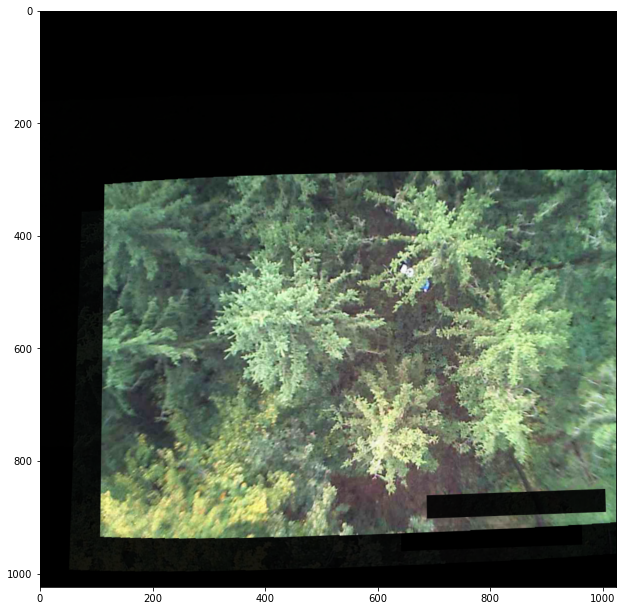

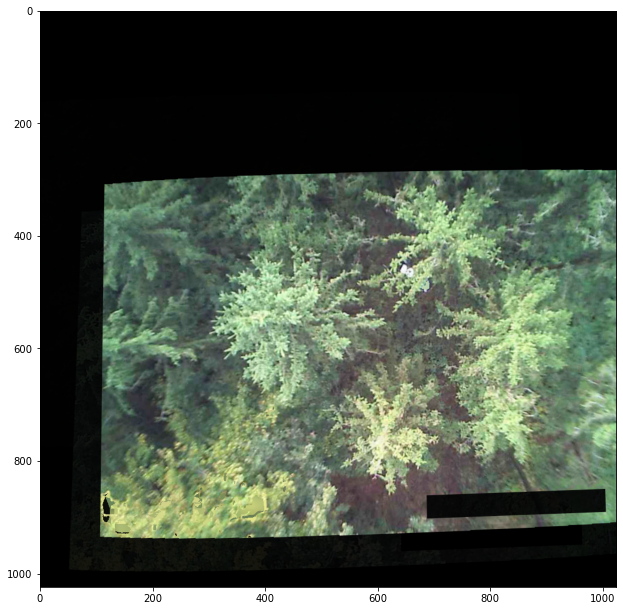

In [8]:
plt.figure(figsize=(10.6, 10.6))
plt.imshow(train_images['train-1-00'])
plt.figure(figsize=(10.6, 10.6))
plt.imshow(purified_train_images[0])

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from tqdm.notebook import trange,tqdm

class ConvAutoEncoder(nn.Module):
    """ Convolutional auto-encoder. """
    
    def __init__(self, in_channels: int = 1, hid_channels: int = 64, code_channels: int = 256, 
                 kernel_size: int = 9, stride: int = 1, pooling: int = 2, 
                 activation: nn.Module = nn.LeakyReLU()):
        """
        Parameters
        ----------
        in_channels : int
            Number of channels in the inputs.
        hid_channels : int
            Number of channels in the hidden layer(s).
        code_channels : int
            Number of channels in the code.
        kernel_size : int or tuple
            Window size for the convolutions
        stride : int or tuple, optional
            Window strides for the convolutions.
        pooling : int or tuple, optional
            Window size for the average pooling.
        activation : nn.Module, optional
            Activation function for the auto-encoder.
        """
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1),
            nn.BatchNorm2d(64),
            activation,
            nn.Conv2d(64, 128, kernel_size=5, stride=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            activation
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, output_padding=0),
            nn.BatchNorm2d(128),
            activation,
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, output_padding=0),
            nn.BatchNorm2d(64),
            activation,
            nn.ConvTranspose2d(64, 3, kernel_size=9, stride=1, output_padding=0),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

cae = ConvAutoEncoder()

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 9, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of feature maps in discriminator
ndf = 64
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# sanity check
cae = ConvAutoEncoder()


In [10]:
if train:
    width = 256
    height = 256
    dim = (width, height)
    purified_train_images_resized = []
    for i in range(len(purified_train_images)):
        im = cv2.resize(purified_train_images[i], dim, interpolation = cv2.INTER_AREA)
        im = im[np.newaxis]
        im = np.moveaxis(im, [0, 1, 2, 3], [0, 3, 2, 1])
        im = torch.Tensor(im)
        purified_train_images_resized.append(im)

    y = cae(purified_train_images_resized[0])
    cae.encoder(purified_train_images_resized[0]).shape

In [11]:
from torch import optim

def _forward(network: nn.Module, data: DataLoader, metric: callable):
    device = next(network.parameters()).device
    
    for x, y in data:
        x, y = x.to(device), y.to(device)
        logits = network(x)
        res = metric(logits, y)
        yield res


@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    network.eval()
    
    results = _forward(network, data, metric)
    return [res.item() for res in results]
    

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module, 
           opt: optim.Optimizer) -> list:
    network.train()
    
    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        
        opt.zero_grad()
        err.backward()
        opt.step()
    
    return errs


def train_auto_encoder(auto_encoder: nn.Module, loader: DataLoader, 
                       objective: nn.Module, optimiser: optim.Optimizer, 
                       num_epochs: int = 10, vis_every: int = 1):
    """
    Train an auto-encoder for a number of epochs.
    
    Parameters
    ----------
    auto_encoder : nn.Module
        The auto-encoder to train
    loader : DataLoader
        A data loader for iterating over batches of the data.
    objective : nn.Module
        The loss function to optimise during training.
    optimiser : optim.Optimizer
        The optimiser to use for training.
    num_epochs : int, optional
        Number of times to iterate the dataset.
    vis_every : int, optional
        Frequency, during training, of 
        intermediate visualisation of reconstructions.
    """
    # take random batch for visualising reconstructions
    ref_inputs, _ = next(iter(loader))
    
    # evaluate random performance
    errs = evaluate(auto_encoder, loader, objective)
    print(f"Epoch {0: 2d} - avg loss: {sum(errs) / len(errs):.6f}")
    display_result(auto_encoder, ref_inputs)
    
    # train for some epochs
    for epoch in range(1, num_epochs + 1):
        errs = update(auto_encoder, loader, objective, optimiser)
        print(f"Epoch {epoch: 2d} - avg loss: {sum(errs) / len(errs):.6f}")

        if epoch % vis_every == 0:
            display_result(auto_encoder, ref_inputs)
            
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm.notebook import trange,tqdm
import gc
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 1

#dataroot ='data/train'
#dataset = dset.ImageFolder(root=dataroot,
#                           transform=transforms.Compose([
#                               transforms.Resize(image_size),
#                               transforms.CenterCrop(image_size),
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                           ]))

if train:
    dataset = purified_train_images_resized
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

    learning_rate = 1e-3
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(cae.parameters(), lr=learning_rate, weight_decay=1e-5)
    num_epochs = 10
    for epoch in range(num_epochs):
        loss = 0
        for batch_features in dataloader:
            im = torch.squeeze(batch_features, dim=0)
            im = nn.functional.normalize(im)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimiser.zero_grad()

            # compute reconstructions
            outputs = cae(im)
            # compute training reconstruction loss
            train_loss = criterion(outputs, im)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimiser.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(dataloader)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss))

epoch : 1/10, loss = 0.518606
epoch : 2/10, loss = 0.265586
epoch : 3/10, loss = 0.194355
epoch : 4/10, loss = 0.174114
epoch : 5/10, loss = 0.164674
epoch : 6/10, loss = 0.157713
epoch : 7/10, loss = 0.155396
epoch : 8/10, loss = 0.153773
epoch : 9/10, loss = 0.152435
epoch : 10/10, loss = 0.151355


In [12]:
if train:
    torch.save(cae,'cae.pth')

In [13]:
if train:
    cae = torch.load('cae.pth', map_location='cpu')
    cae.eval();

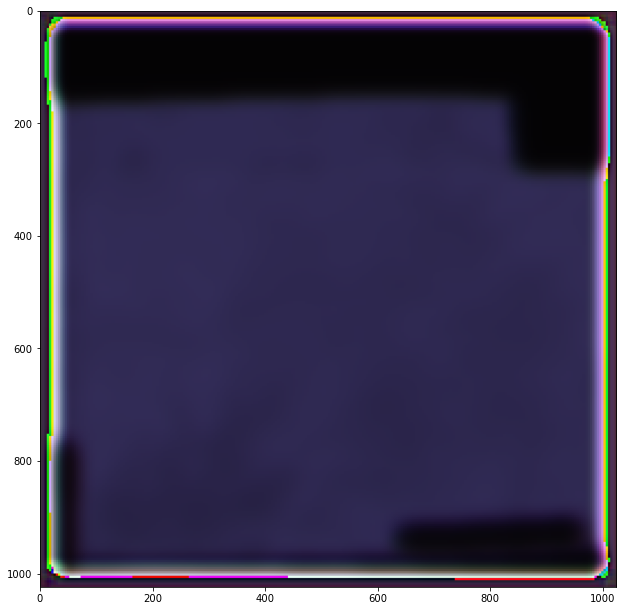

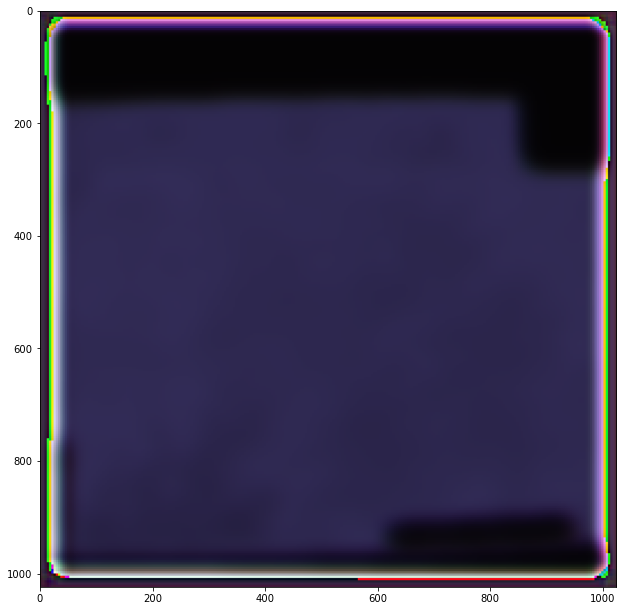

In [14]:
if train:
    width = 256
    height = 256
    dim = (width, height)

    test_image = train_images['train-2-10']    
    test_image = cv2.resize(test_image, dim, interpolation = cv2.INTER_AREA)
    test_image = test_image[np.newaxis]
    test_image = np.moveaxis(test_image, [0, 1, 2, 3], [0, 3, 2, 1])
    test_image = torch.Tensor(test_image)

    reconstructed = cae.forward(nn.functional.normalize(purified_train_images_resized[0]))
    reconstructed = torch.squeeze(reconstructed.detach()).T
    width = 1024
    height = 1024
    dim = (width, height)
    reconstructed = cv2.resize(reconstructed.cpu().detach().numpy(), dim, interpolation = cv2.INTER_AREA)

    plt.figure(figsize=(10.6, 10.6))
    plt.imshow((reconstructed * 255).astype(np.uint8))

    reconstructed = cae.forward(nn.functional.normalize(test_image))
    reconstructed = torch.squeeze(reconstructed.detach()).T
    width = 1024
    height = 1024
    dim = (width, height)
    reconstructed = cv2.resize(reconstructed.cpu().detach().numpy(), dim, interpolation = cv2.INTER_AREA)

    plt.figure(figsize=(10.6, 10.6))
    plt.imshow((reconstructed * 255).astype(np.uint8))

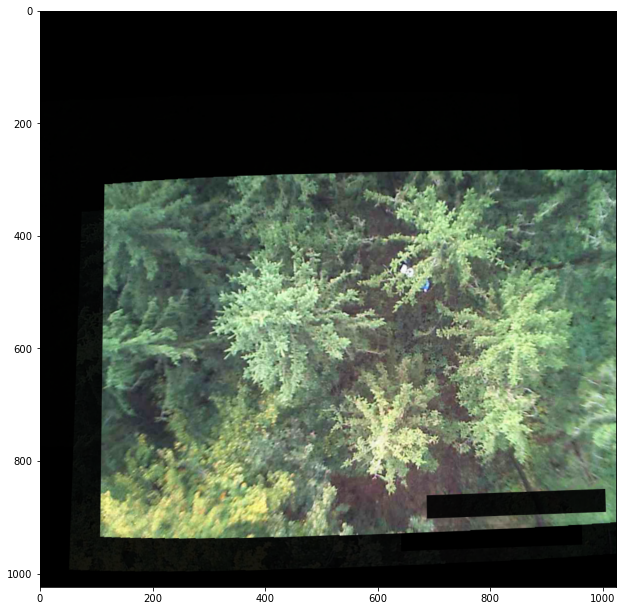

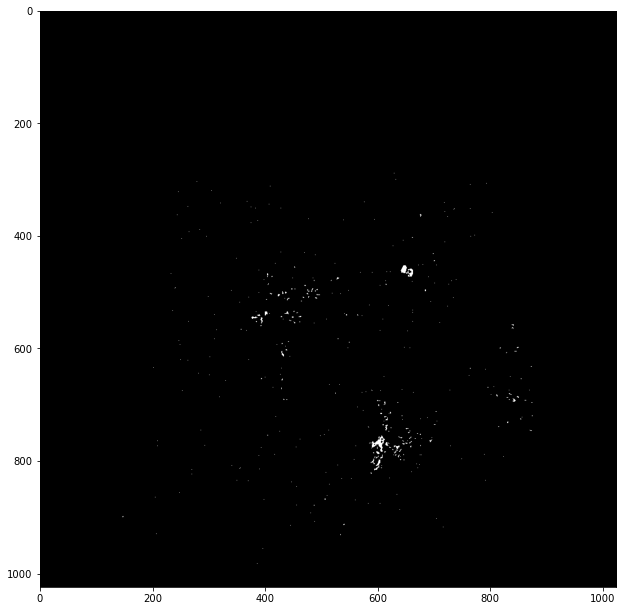

In [30]:
def rCRD(image, r, l): 
    d = image.shape[2]
    n = image.shape[0]*image.shape[1]
    X = image.reshape((d,n)).astype(np.uint8)
    #X = X.reshape((image.shape[0],image.shape[1],image.shape[2]))
    Xr = np.zeros((d,r)).astype(np.uint8)
    A = np.zeros((r,n)).astype(np.uint8)
    Xsampled = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
    
    for i in range(r):
        x = np.random.randint(0, image.shape[0])
        y = np.random.randint(200, image.shape[1]-200)
        #Xsampled[x,y,:] = image[x,y,:]
        Xr[:,i] = image[x,y]
    #Xr = Xsampled.reshape((d,r))
    A = np.linalg.pinv(Xr.T@Xr + l*np.eye(r))@Xr.T@X
        
    delta = np.zeros(n)
    anomaly = np.zeros(n)
    for i in range(n):
        delta[i] = np.linalg.norm(X[:,i]-Xr@A[:,i],2)

    threshold = np.mean(delta)
    for i in range(n):
        if delta[i] > threshold:
            anomaly[i] = 1
        else:
            anomaly[i] = 0
    anomaly = anomaly.reshape((image.shape[0], image.shape[1]))
    delta = delta.reshape((image.shape[0], image.shape[1]))
    return delta

def rCRD_XY(image, r, l, threshold):
    d = image.shape[2]
    n = image.shape[0]*image.shape[1]
    X = image.copy()
    Xr = np.zeros_like(X)
    A = np.zeros_like(X)
    
    for i in range(r):
        x = np.random.randint(0, image.shape[1])
        y = np.random.randint(200, image.shape[0]-200)
        #sample = np.random.randint(0, n)
        #Xr[:,i] = X[:,sample]
        #Xr[t, :,i] = X[:,sample]
        Xr[x,y] = X[x,y]
        #points = cv2.circle(X, (x,y), radius=3, color=(0, 0, 255), thickness=-1)
    
    for m in range(X.shape[0]):
        for n in range(X.shape[1]):
            A[m,n] = 1/(Xr[m,n].T*Xr[m,n] + l) * Xr[m,n].T*X[m,n]
    
    delta = np.zeros((X.shape[0], X.shape[1]))
    anomaly = np.zeros_like(delta)
    
    
    for m in range(X.shape[0]):
        for n in range(X.shape[1]):
            delta[m,n] = np.linalg.norm(X[m,n]-Xr[m,n]@A[m,n],2)
            
    delta = delta/np.max(delta)
    for m in range(X.shape[0]):
        for n in range(X.shape[1]):     
            if delta[m,n] > threshold:
                anomaly[m,n] = 1
            else:
                anomaly[m,n] = 0

    return anomaly


image = train_images['train-1-00']
anomaly = rCRD_XY(image, r=5000, l=1e-6, threshold=0.9)

plt.figure(figsize=(10.6, 10.6))
plt.imshow(image)
plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly, cmap='gray')
plt.show()

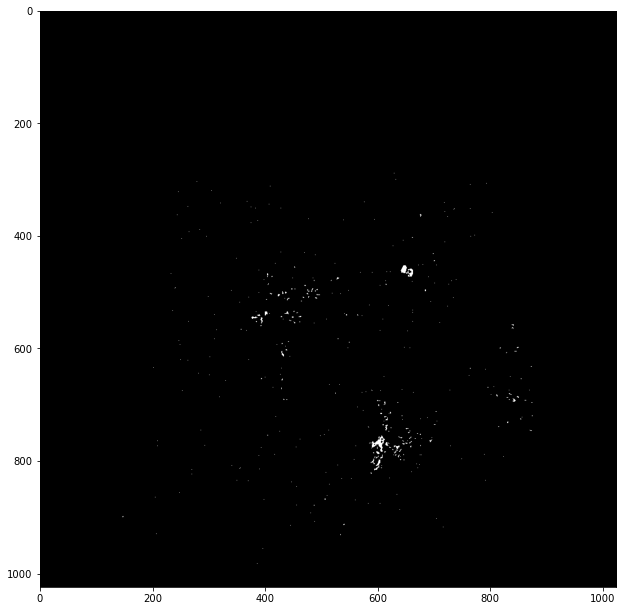

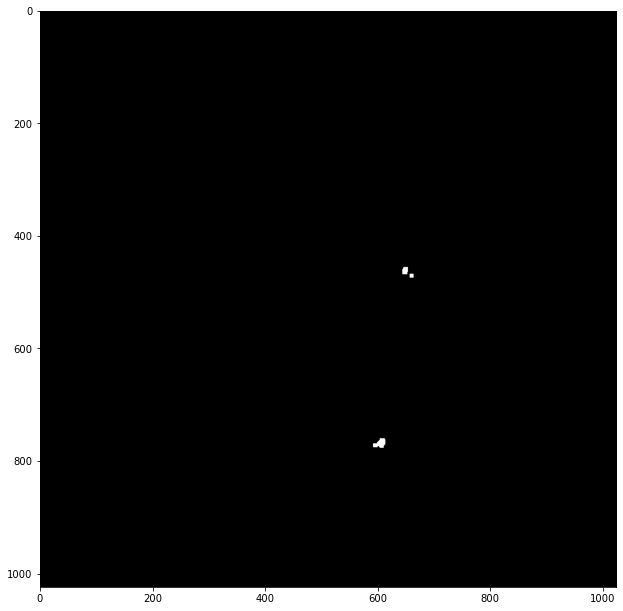

In [81]:
gray = anomaly.copy()
# plt.figure(figsize=(10.6, 10.6))
# plt.imshow(gray)
# plt.show()

# gray level needs to be ensured 'uint8'
gray = gray.astype("uint8")

blur = cv2.GaussianBlur(gray, (3,3), 0)

thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Filter using contour area and remove small noise
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 5500:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Morph close and invert image
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4)) # change kernel size for bigger/smaller blurring
close = 255 - cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)


plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly, cmap='gray')
plt.figure(figsize=(10.6, 10.6))
plt.imshow(cv2.cvtColor(close, cv2.COLOR_BGR2RGB))
plt.show()


Box coordinates for detected objects (x,y,w,h): [(591, 760, 22, 17), (656, 468, 7, 7), (643, 456, 10, 13)]


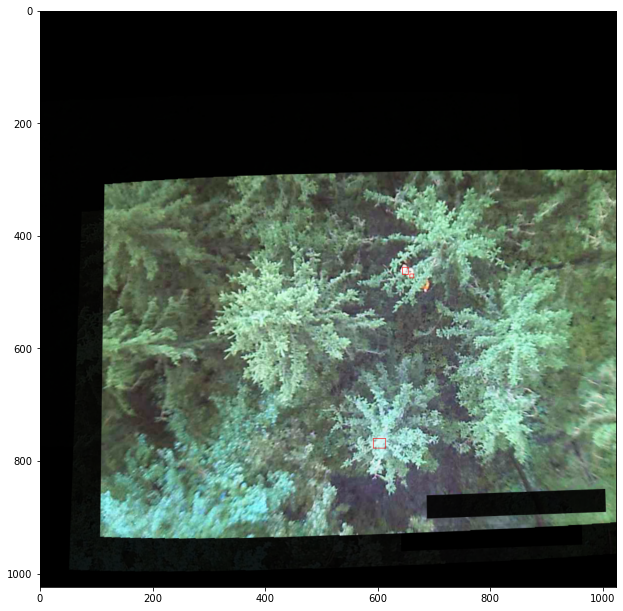

In [88]:
# Draw the bounding boxes on the filtered image
gray_ = close.copy()
image_ = image.copy()


# threshold
thresh_ = cv2.threshold(gray_,128,255,cv2.THRESH_BINARY)[1]

# get contours
contours = cv2.findContours(thresh_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
detected_boxes = []
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    detected_boxes.append((x,y,w,h))
    cv2.rectangle(gray_, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.rectangle(image_, (x, y), (x+w, y+h), (0, 0, 255), 1)
print('Box coordinates for detected objects (x,y,w,h):', detected_boxes)
  
plt.figure(figsize=(10.6, 10.6))
plt.imshow(cv2.cvtColor(image_, cv2.COLOR_BGR2RGB))
plt.show()
